In [1]:
!pip install replay-rec rs_datasets lightfm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 kB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.5/231.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 85.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 3.4 M

In [2]:
import random
import warnings
warnings.simplefilter(action='ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from lightfm import LightFM
from lightfm.data import Dataset
from replay.metrics import HitRate, NDCG, Coverage, Experiment
from replay.preprocessing.filters import MinCountFilter, LowRatingFilter
from replay.splitters import TimeSplitter
from rs_datasets import MovieLens

In [3]:
random.seed(0)
np.random.seed(0)

In [4]:
USER_COL = 'user_id'
ITEM_COL = 'item_id'
RATING_COL = 'rating'
TIMESTAMP = 'timestamp'

In [5]:
SEED = 0

In [6]:
data = MovieLens("1m")
data.info()

INFO:rs_datasets:Downloading ml-1m from grouplens...
5.93MB [00:00, 9.19MB/s]                            


ratings


,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968



users


,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117



items


,item_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [7]:
ratings, items, users = data.ratings, data.items, data.users

## EDA

### Users

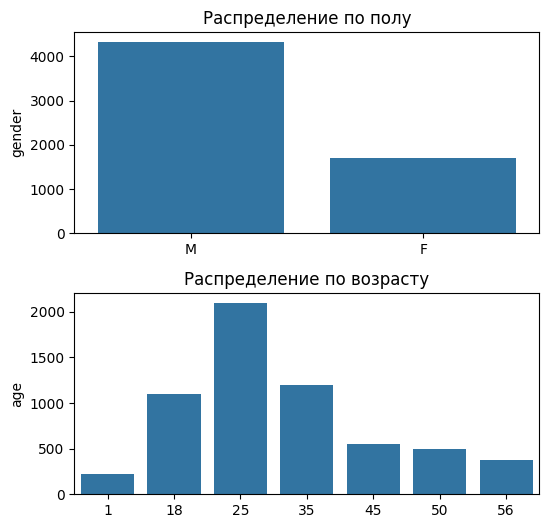

In [8]:
fig, axs = plt.subplots(nrows=2 , ncols=1, figsize=(6, 6))
plt.subplots_adjust(hspace=0.3)
sns.barplot(users['gender'].value_counts(), ax=axs[0])
axs[0].set_title('Распределение по полу')
sns.barplot(users['age'].value_counts(), ax=axs[1])
axs[1].set_title('Распределение по возрасту')
fig.show()

### Items

In [9]:
items['year'] = items['title'].str.split('(').apply(lambda x: int(x[-1][:-1]))
items['genres'] = items['genres'].str.split('|')

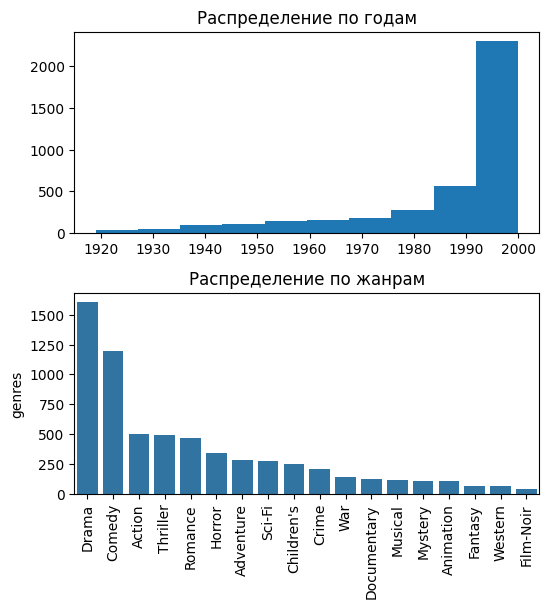

In [10]:
fig, axs = plt.subplots(nrows=2 , ncols=1, figsize=(6, 6))
plt.subplots_adjust(hspace=0.3)
axs[0].hist(items['year'], bins=10)
axs[0].set_title('Распределение по годам')
sns.barplot(items['genres'].explode().value_counts(), ax=axs[1])
axs[1].set_title('Распределение по жанрам')
plt.xticks(rotation=90)
fig.show()

## Предобработка данных

В датасете содержатся только пользователи с более чем 20 просмотренными фильмами. Отфильтруем фильмы, у которых менее 20 просмотров.

In [11]:
ratings = MinCountFilter(num_entries=20, groupby_column=ITEM_COL).transform(ratings)

In [12]:
print(f'Количество уникальных пользователей: {ratings[USER_COL].nunique()}')
print(f'Количество уникальных фильмов: {ratings[ITEM_COL].nunique()}')

Количество уникальных пользователей: 6040
Количество уникальных фильмов: 3043


## train-test split

Разделим данные по времени так, чтобы 20% взаимодействий оказалось в тестовой выборке. Исключим из тестовой выборки холодных пользователей и холодные объекты.

In [13]:
train, test = TimeSplitter(time_threshold=0.2,
                           query_column=USER_COL,
                           item_column=ITEM_COL,
                           drop_cold_users=True,
                           drop_cold_items=True).split(ratings)
train.shape, test.shape

((796392, 4), (103764, 4))

In [14]:
test = LowRatingFilter(value=4, rating_column=RATING_COL).transform(test)
test.shape

(55988, 4)

## Подготовка данных для LightFM

Оставим в таблицах users и items только тех пользователей и фильмы, которые присутствуют в train.

In [15]:
ALL_USERS = train[USER_COL].unique().tolist()
ALL_MOVIES = train[ITEM_COL].unique().tolist()

users = users[users[USER_COL].isin(ALL_USERS)]
items = items[items[ITEM_COL].isin(ALL_MOVIES)]

Передадим список пользователей и фильмов для построения датасета.

In [16]:
dataset = Dataset()
dataset.fit_partial(ALL_USERS, ALL_MOVIES)

Получим сопоставление id и индексов датасета.

In [17]:
user_mapping = dataset.mapping()[0]
item_mapping = dataset.mapping()[2]
inv_user_mapping = {v:k for k, v in user_mapping.items()}
inv_item_mapping = {v:k for k, v in item_mapping.items()}

Построим матрицу взаимодействий для обучения модели. Веса (weights) отражают то, насколько фильм понравился пользователю. В нашем случае это rating.

In [18]:
train_interactions, train_weights = dataset.build_interactions(train[[USER_COL, ITEM_COL, RATING_COL]].values)
train_interactions, train_weights

(<5399x3041 sparse matrix of type '<class 'numpy.int32'>'
 	with 796392 stored elements in COOrdinate format>,
 <5399x3041 sparse matrix of type '<class 'numpy.float32'>'
 	with 796392 stored elements in COOrdinate format>)

## LightFM

При обучении модели идет построение векторных представлений для каждого признака пользователя и объекта. Если признаков нет, то используются только индикаторные признаки (единичная матрица по пользователям и объектам соответственно)

Векторы пользователя и объекта получаются суммированием векторов их признаков.

$$\hat{r}_{ui} = f(q_u \cdot p_i + b_u + b_i)$$

$$q_u = \sum_{j \in f_u} e_j^U$$
$$p_i = \sum_{j \in f_i} e_j^I$$
$$b_u = \sum_{j \in f_u} b_j^U$$
$$b_i = \sum_{j \in f_i} b_j^I$$
где $q_u, p_i$ - векторы пользователя и объекта, являющиеся суммой векторов их признаков

$b_u, b_i$ - смещения для признаков пользователя и объекта

### LightFM без признаков

In [19]:
class LightFM4Rec:
    def __init__(
        self,
        model,
        user_mapping,
        item_mapping,
        inv_user_mapping,
        inv_item_mapping,
        user_col=USER_COL,
        item_col=ITEM_COL,
        rating_col=RATING_COL,
    ):
        self.model = model
        self.user_mapping = user_mapping
        self.item_mapping = item_mapping
        self.inv_user_mapping = inv_user_mapping
        self.inv_item_mapping = inv_item_mapping
        self.user_col = user_col
        self.item_col = item_col
        self.rating_col = rating_col

    def fit(self, rating_matrix, user_features=None, item_features=None, epochs=50):
        self.user_features = user_features
        self.item_features = item_features
        self.model.fit(
            rating_matrix,
            user_features=self.user_features,
            item_features=self.item_features,
            epochs=epochs,
            num_threads=8,
        )

    def _get_lfm_pred(self, user_id):
        pred_for_user = self.model.predict(
            user_ids=user_id,
            item_ids=self.item_ids,
            user_features=self.user_features,
            item_features=self.item_features,
        )
        return pred_for_user

    def predict(self, test, interaction_matrix=None, filter_seen=True, k=10):
        user_ids = test[USER_COL].map(self.user_mapping).unique()
        self.item_ids = list(self.item_mapping.values())

        pred = pd.DataFrame(user_ids, columns=[USER_COL])
        scores = np.vstack(pred[USER_COL].apply(self._get_lfm_pred).values)

        if filter_seen:
            scores += np.nan_to_num(interaction_matrix.todense()[user_ids] * -np.inf)

        ind_part = np.argpartition(scores, -k)[:, -k:].copy()
        scores_not_sorted = np.take_along_axis(scores, ind_part, axis=1)
        ind_sorted = np.argsort(scores_not_sorted, axis=1)
        scores_sorted = np.sort(scores_not_sorted, axis=1)
        indices = np.take_along_axis(ind_part, ind_sorted, axis=1)

        preds = pd.DataFrame(
            {
                self.user_col: user_ids,
                self.item_col: np.flip(indices, axis=1).tolist(),
                self.rating_col: np.flip(scores_sorted, axis=1).tolist(),
            }
        ).explode([self.item_col, self.rating_col])
        preds[self.user_col] = preds[self.user_col].map(self.inv_user_mapping)
        preds[self.item_col] = preds[self.item_col].map(self.inv_item_mapping)

        return preds

In [20]:
model = LightFM4Rec(
    LightFM(random_state=SEED, loss="warp", no_components=20),
    user_mapping,
    item_mapping,
    inv_user_mapping,
    inv_item_mapping,
)
model.fit(train_weights)

In [21]:
preds_without_futures = model.predict(test, train_interactions)
preds_without_futures.head()

,user_id,item_id,rating
0,636,1376,0.394137
0,636,3527,0.335793
0,636,1214,0.319899
0,636,1200,0.28374
0,636,2657,0.176353


### LightFM c признаками

Матрицы призанаков пользователей/объектов представляют собой разреженные матрицы размера количество пользователей/объектов $\times$ количество признаков. Построим такие матрицы.

In [22]:
users.head()

,user_id,gender,age,occupation,zip_code
635,636,M,18,20,92055
636,637,M,35,12,97132
637,638,M,25,6,77584
638,639,M,45,17,85202
639,640,M,18,4,47406


In [23]:
user_features = users.copy()
user_features['gender'] = user_features['gender'].apply(lambda x: [x])
user_features['age'] = user_features['age'].apply(lambda x: [x])
user_features['features'] = user_features['gender'] + user_features['age']
user_tags = user_features['features'].explode().unique()

In [24]:
user_tags

array(['M', 18, 35, 25, 45, 'F', 56, 50, 1], dtype=object)

In [25]:
items.head()

,item_id,title,genres,year
0,1,Toy Story (1995),"[Animation, Children's, Comedy]",1995
1,2,Jumanji (1995),"[Adventure, Children's, Fantasy]",1995
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",1995
3,4,Waiting to Exhale (1995),"[Comedy, Drama]",1995
4,5,Father of the Bride Part II (1995),[Comedy],1995


In [26]:
item_features = items.copy()
item_features['year'] = item_features['year'].apply(lambda x: [x])
item_features['features'] = item_features['year'] + item_features['genres']
item_tags = item_features['features'].explode().unique()

In [27]:
item_tags

array([1995, 'Animation', "Children's", 'Comedy', 'Adventure', 'Fantasy',
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Sci-Fi', 'War', 'Musical', 1994, 1996, 'Documentary', 1976,
       'Mystery', 1993, 1992, 1967, 'Film-Noir', 1964, 'Western', 1977,
       1965, 1982, 1990, 1991, 1989, 1937, 1940, 1969, 1981, 1973, 1970,
       1960, 1955, 1956, 1959, 1968, 1988, 1975, 1948, 1963, 1997, 1972,
       1943, 1952, 1951, 1957, 1961, 1958, 1954, 1934, 1944, 1942, 1941,
       1953, 1939, 1950, 1946, 1945, 1938, 1947, 1935, 1936, 1926, 1949,
       1932, 1930, 1974, 1971, 1979, 1987, 1986, 1980, 1978, 1985, 1966,
       1962, 1983, 1984, 1933, 1931, 1922, 1998, 1927, 1929, 1999, 1919,
       1925, 2000, 1928, 1920, 1921], dtype=object)

Передадим список признаков пользователей и фильмов для построения датасета.

In [28]:
dataset.fit_partial(user_features=user_tags, item_features=item_tags)

In [29]:
sparse_i_features = dataset.build_item_features(
    [[row.item_id, row.features] for row in item_features.reset_index().itertuples()]
)
sparse_u_features = dataset.build_user_features(
    [[row.user_id, row.features] for row in user_features.reset_index().itertuples()]
)

In [30]:
model = LightFM4Rec(
    LightFM(random_state=SEED, loss="warp", no_components=20),
    user_mapping,
    item_mapping,
    inv_user_mapping,
    inv_item_mapping,
)
model.fit(train_weights, sparse_u_features, sparse_i_features)

In [31]:
preds_with_futures = model.predict(test, train_interactions)
preds_with_futures.head()

,user_id,item_id,rating
0,636,1214,-188.336472
0,636,1258,-188.394989
0,636,1270,-188.930664
0,636,1387,-189.06398
0,636,196,-189.162811


# Метрики

In [32]:
K = [10]
metrics = Experiment(
    [
        NDCG(K),
        HitRate(K),
        Coverage(K)
    ],
    test,
    train,
    query_column=USER_COL,
    item_column=ITEM_COL,
    rating_column=RATING_COL,
)

In [33]:
metrics.add_result("LightFM without features", preds_without_futures)
metrics.add_result("LightFM with features", preds_with_futures)
metrics.results

,NDCG@10,HitRate@10,Coverage@10
LightFM without features,0.207696,0.643750,0.333772
LightFM with features,0.231004,0.660714,0.238080
